In [ ]:
import sys,os
import configargparse

import torch
import numpy as np

from srns import *
import util

_MODEL_PATH = './logs/032410face_seg_one_shot/checkpoints/epoch_0479_iter_060000.pth'

_TOT_NUM_INSTANCES = 1001

model = SRNsModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  fit_single_srn=False,
                  use_unet_renderer=False,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=19,
                  img_sidelength=128,
                  output_sidelength=512
                 )

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=False)

model.eval()
model.cuda()

In [ ]:
from dataset.face_dataset import FaceClassDataset
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

import cv2
import imageio

train_dataset = FaceClassDataset(
    root_dir='/data/anpei/facial-data/seg_face_2000', 
    data_type='seg',
    img_sidelength=128, 
    sample_observations=[13], 
    sample_instances=list(range(100)),
    load_depth=False)

train_dataset = DataLoader(train_dataset,
                           collate_fn=train_dataset.collate_fn,
                           batch_size=8,
                           shuffle=False,
                           drop_last=False)

with torch.no_grad():

    for idx, model_input in enumerate(train_dataset):
        model_input, ground_truth = model_input
        
        pose = model_input['pose']
        intrinsics = model_input['intrinsics']
        uv = model_input['uv']
        z = model.get_embedding(model_input)
        
        model_outputs = model(pose, z, intrinsics, uv)
        print(model_outputs[0].shape, ground_truth['rgb'].shape)
        
        dist_loss = model.get_cls_loss(model_outputs, ground_truth)
        print(np.mean(dist_loss.cpu().numpy()))

In [ ]:
from dataset.face_dataset import FaceRandomPoseDataset
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

import cv2
import imageio

_OUTPUT_DIR = './logs/032410face_seg_one_shot/output_iter_060000'
_MODE = 'sphere'
_R = 1.2

_NUM_INSTANCES=3
_NUM_OBSERVATIONS=50

output_dir = os.path.join(_OUTPUT_DIR, _MODE)
sample_instances = list(np.random.choice(range(_TOT_NUM_INSTANCES), _NUM_INSTANCES, replace=False))

# writer = SummaryWriter(output_dir)

dataset = FaceRandomPoseDataset(
    num_instances=sample_instances, num_observations=_NUM_OBSERVATIONS, sample_radius=_R, mode=_MODE)

dataloader = DataLoader(dataset,
                     collate_fn=dataset.collate_fn,
                     batch_size=1,
                     shuffle=False,
                     drop_last=False)

print('Beginning evaluation...')

images = {}

with torch.no_grad():

    for idx, model_input in enumerate(dataloader):
        model_input, ground_truth = model_input
        
        pose = model_input['pose']
        intrinsics = model_input['intrinsics']
        uv = model_input['uv']
        z = model.get_embedding(model_input)
        
        model_outputs = model(pose, z, intrinsics, uv)
        predictions, depth_maps = model_outputs
                
        batch_size, tensor_len, channels = predictions.shape
        img_sidelen = np.sqrt(tensor_len).astype(int)
                
        pred = torch.argmax(predictions, dim=2, keepdim=True)
        output_img = util.lin2img(pred, color_map=dataset.color_map).cpu().numpy()
        output_pred = pred.view(batch_size, img_sidelen, img_sidelen, 1).cpu().numpy()
#         output_dpt = util.lin2img(depth_maps).cpu().numpy()
#         output_dpt = (output_dpt - np.min(output_dpt)) / (np.max(output_dpt)-np.min(output_dpt) + 1e-5)
#         print(idx, 'depth = ', np.max(output_dpt), np.min(output_dpt), output_dpt.shape)
        
#         model.write_updates(writer, model_outputs, iter=idx, mode='test')

        for i in range(output_img.shape[0]):
            instance_idx = int(model_input['instance_idx'][i].squeeze().detach().cpu().numpy().astype(np.int64))
            observation_idx = model_input['observation_idx'][i]
            
            instance_dir = os.path.join(output_dir, "%03d" % instance_idx)
            os.makedirs(instance_dir, exist_ok=True)
            
            img = output_img[i, :, :, :].squeeze().transpose(1, 2, 0)
            img *= 255
            img = img.round().clip(0, 255).astype(np.uint8)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

            if not instance_idx in images:
                images[instance_idx] = [None] * _NUM_OBSERVATIONS

            images[instance_idx][observation_idx] = img
#             output_fp = os.path.join(instance_dir, '%02d.png'%(observation_idx))
#             util.write_img(img, output_fp)
            
            output_fp = os.path.join(instance_dir, '%02d_seg.png'%(observation_idx))
            seg_img = output_pred[i, :, :].squeeze().astype(np.uint8)
            util.write_img(seg_img, output_fp)
            
#             dpt_img = (output_dpt[i, :, :, :].squeeze() * 255.0).astype(np.uint8)
#             dpt_img = cv2.applyColorMap(dpt_img, cv2.COLORMAP_JET)
#             output_fp = os.path.join(instance_dir, '%02d_depth.png'%(observation_idx))
# #             print('Save output for instance %03d - %02d: %s'%(instance_idx, observation_idx, output_fp))
#             util.write_img(dpt_img, output_fp)
            print('Save output for instance %04d - %02d: %s'%(instance_idx, observation_idx, output_fp))
        
            if observation_idx == _NUM_OBSERVATIONS - 1:
                imageio.mimsave(os.path.join(instance_dir, 'output.gif'), images[instance_idx], fps=5.0)
                print('=== [DONE] saving output.gif.')
            
#         print('[DONE] Save output for instance %03d.'%(instance_idx))


In [ ]:
# move seg_face_8000
import os
from glob import glob
from shutil import copyfile

data_root = '/data/anpei/facial-data/seg_face_8000/images'
img_fps = glob(os.path.join(data_root, '*_seg_*.png'))
img_ids = list(set([os.path.basename(x)[:5] for x in img_fps]))

for img_id in img_ids:
    output_dir = os.path.join(data_root, img_id)
    os.makedirs(output_dir, exist_ok=True)
    copyfile(
        os.path.join(data_root, '..', 'cam2world.npy'), 
        os.path.join(output_dir, 'cam2world.npy'))
    
    img_fps = glob(os.path.join(data_root, '%s_seg_*.png'%(img_id)))
    print(output_dir, len(imgs))
    for img_fp in sorted(img_fps):
        out_name = os.path.basename(img_fp).split('_')
        out_sub_dir = out_name[0]
        out_name = '_'.join([out_name[1], '%02d'%(int(out_name[-2])*5+int(out_name[-1][:2]))]) + '.png'
        out_name = os.path.join(os.path.dirname(img_fp), out_sub_dir, out_name)
#         print('\t> ', img_fp, out_name)
        os.rename(img_fp, out_name)

In [ ]:
import os
import numpy as np

data_dir = '/data/anpei/facial-data/seg_face_2000/10996'

cam_param = np.load(os.path.join(data_dir, 'cameras.npy'), allow_pickle=True).item() 
print(np.asarray(cam_param['zRange']).shape, np.asarray(cam_param['extrinsics']).shape)

In [ ]:
import torchvision.models as torch_models
import torch

resnet_model = torch_models.resnet18(pretrained=False)
# resnet_model.layer4 = torch.nn.Identity()
# resnet_model.fc = torch.nn.Identity()
resnet_model.conv1 = torch.nn.Conv2d(19, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print(resnet_model)

In [ ]:
a = resnet_model(torch.Tensor(8, 19, 128, 128))
print(a.shape)

In [ ]:
import torch
from torch.nn import functional as F

aa = torch.randint(0, 19, size=(1, 3, 3))
print(aa.shape)

bb = F.one_hot(aa)
print(bb.shape, bb[0])

In [ ]:
aa = torch.empty(256)
print(aa.shape)

In [36]:
import cv2

instance_dir = '/data/anpei/facial-data/seg_body/94'
seg_imgs = img = cv2.imread(os.path.join(instance_dir, 'semantic_mask', 'image.cam05_000094.png'), cv2.IMREAD_UNCHANGED).astype(np.float32)
print(np.unique(seg_imgs))


fs = cv2.FileStorage("/data/anpei/facial-data/seg_body/Calib_T_samba/cam05_000000/intrinsic.xml", cv2.FILE_STORAGE_READ)
intrinsics = fs.getNode("M").mat()

print(intrinsics)

H, W = seg_imgs.shape
cx, cy = intrinsics[:2, 2]

x_coord, y_coord = np.where(seg_imgs != 0)
bbox = np.asarray([np.min(x_coord), np.min(y_coord), np.max(x_coord), np.max(y_coord)])
print(bbox)

sidelength = max(bbox[2] - bbox[0], bbox[3] - bbox[1])
center = np.asarray([bbox[2] + bbox[0], bbox[3] + bbox[1]]) / 2.0
bbox = np.ceil(np.asarray([
    center[0]-sidelength/2.0, 
    center[1]-sidelength/2.0, 
    center[0]+sidelength/2.0,
    center[1]+sidelength/2.0])).astype(np.int64)

cx, cy = intrinsics[:2, 2] - bbox[:2]

print(bbox, bbox.dtype)
seg_imgs = seg_imgs[bbox[0]:bbox[2], bbox[1]:bbox[3]]
print(seg_imgs.shape)


print(cx, cy, bbox)
intrinsics[:2, 2] = [cx, cy]
print(intrinsics)


print(H, W, cx, cy)

[  0.  10.  20.  30.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150.]
[[1.10482111e+03 0.00000000e+00 7.91688039e+02]
 [0.00000000e+00 1.10435260e+03 6.12305434e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 288  735  855 1009]
[ 288  589  855 1156] int64
(567, 567)
503.688039 23.30543399999999 [ 288  589  855 1156]
[[1.10482111e+03 0.00000000e+00 5.03688039e+02]
 [0.00000000e+00 1.10435260e+03 2.33054340e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
1200 1600 503.688039 23.30543399999999


> Load 2 instances from /data/anpei/facial-data/seg_body.
10
>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[-0.6751, -0.3836,  0.6301, -2.6013],
         [-0.0140, -0.8473, -0.5309,  2.7542],
         [ 0.7376, -0.3672,  0.5667, -2.0908],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1081e+03, 0.0000e+00, 7.8727e+02, 0.0000e+00],
         [0.0000e+00, 1.1070e+03, 6.0741e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.]


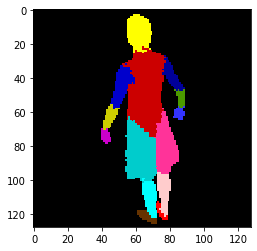

>  [ 0.  1.  2.  4.  6.  7.  8.  9. 10. 11. 12. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[ 0.9987, -0.0077, -0.0500,  0.0554],
         [-0.0383, -0.7606, -0.6481,  2.7474],
         [-0.0330,  0.6492, -0.7599,  2.1227],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1019e+03, 0.0000e+00, 8.1243e+02, 0.0000e+00],
         [0.0000e+00, 1.1022e+03, 6.0238e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  4.  6.  7.  8.  9. 10. 11. 12. 14. 15.]


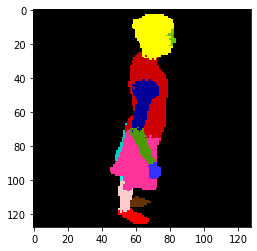

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[ 0.6957,  0.3931, -0.6013,  2.5896],
         [ 0.0212, -0.8479, -0.5297,  2.7699],
         [-0.7181,  0.3557, -0.5982,  2.1870],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1083e+03, 0.0000e+00, 8.0637e+02, 0.0000e+00],
         [0.0000e+00, 1.1085e+03, 6.0109e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


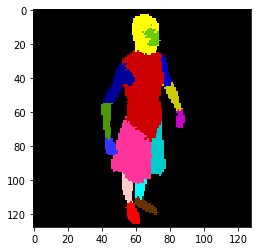

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[-0.6360,  0.4074, -0.6553,  2.6195],
         [ 0.0159, -0.8422, -0.5390,  2.7542],
         [-0.7715, -0.3533,  0.5292, -2.0908],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1164e+03, 0.0000e+00, 8.0493e+02, 0.0000e+00],
         [0.0000e+00, 1.1174e+03, 6.0064e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


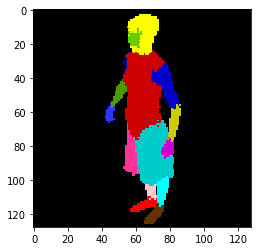

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[ 0.0028, -0.5674,  0.8234, -2.5839],
         [-0.0435, -0.8227, -0.5668,  2.7426],
         [ 0.9990, -0.0342, -0.0270, -0.0839],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1005e+03, 0.0000e+00, 8.0037e+02, 0.0000e+00],
         [0.0000e+00, 1.1004e+03, 5.9152e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.]


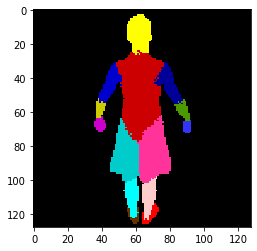

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[ 0.6957,  0.3931, -0.6013,  2.5896],
         [ 0.0212, -0.8479, -0.5297,  2.7699],
         [-0.7181,  0.3557, -0.5982,  2.1870],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1083e+03, 0.0000e+00, 8.0637e+02, 0.0000e+00],
         [0.0000e+00, 1.1085e+03, 6.0109e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


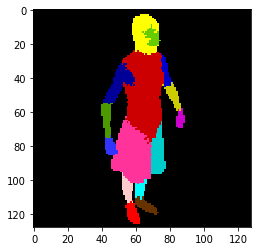

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[-0.6751, -0.3836,  0.6301, -2.6013],
         [-0.0140, -0.8473, -0.5309,  2.7542],
         [ 0.7376, -0.3672,  0.5667, -2.0908],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1081e+03, 0.0000e+00, 7.8727e+02, 0.0000e+00],
         [0.0000e+00, 1.1070e+03, 6.0741e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15.]


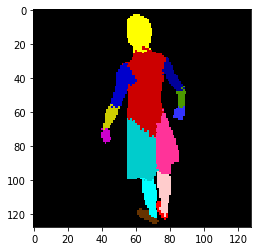

>  [ 0.  1.  2.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[-0.9999,  0.0094,  0.0127, -0.0035],
         [-0.0155, -0.7400, -0.6724,  2.7342],
         [ 0.0031, -0.6726,  0.7400, -2.0470],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1048e+03, 0.0000e+00, 7.9169e+02, 0.0000e+00],
         [0.0000e+00, 1.1044e+03, 6.1231e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


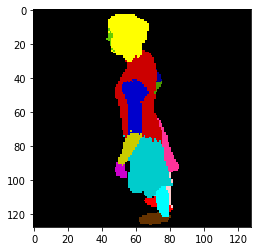

>  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[-0.6360,  0.4074, -0.6553,  2.6195],
         [ 0.0159, -0.8422, -0.5390,  2.7542],
         [-0.7715, -0.3533,  0.5292, -2.0908],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1164e+03, 0.0000e+00, 8.0493e+02, 0.0000e+00],
         [0.0000e+00, 1.1174e+03, 6.0064e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


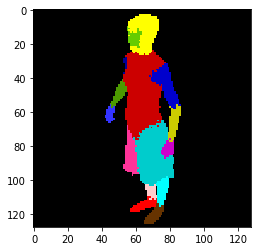

>  [ 0.  1.  2.  4.  6.  7.  8.  9. 10. 11. 12. 14. 15.] torch.Size([1, 16384, 1])
> pose = 
tensor([[[ 0.9987, -0.0077, -0.0500,  0.0554],
         [-0.0383, -0.7606, -0.6481,  2.7474],
         [-0.0330,  0.6492, -0.7599,  2.1227],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
> cam_int = 
tensor([[[1.1019e+03, 0.0000e+00, 8.1243e+02, 0.0000e+00],
         [0.0000e+00, 1.1022e+03, 6.0238e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]])
torch.Size([1, 16384, 1]) [ 0.  1.  2.  4.  6.  7.  8.  9. 10. 11. 12. 14. 15.]


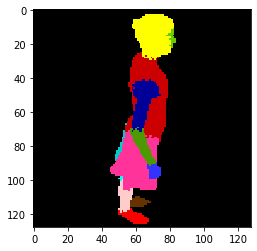

In [2]:
from dataset.body_dataset import BodyPartDataset
from torch.utils.data import DataLoader
import numpy as np

import util

from matplotlib import pyplot as plt

dataset = BodyPartDataset(
        data_type='seg',
        img_sidelength=128, 
        sample_observations=list(range(5)),
        sample_instances=list(range(2)))

dataloader = DataLoader(dataset,
                     collate_fn=dataset.collate_fn,
                     batch_size=1,
                     shuffle=False,
                     drop_last=False)

print(len(dataloader))

for idx, model_input in enumerate(dataloader):
    model_input, ground_truth = model_input
        
    seg_img = model_input['rgb']
    pose = model_input['pose']
    intrinsics = model_input['intrinsics']
    uv = model_input['uv']    
    
    print('> ', np.unique(seg_img), seg_img.shape)
    print('> pose = ')
    print(pose)
    print('> cam_int = ')
    print(intrinsics)
    print(seg_img.shape, np.unique(seg_img))
    
    output_img = util.lin2img(seg_img, color_map=dataset.color_map).cpu().numpy()
    
    plt.imshow(output_img.squeeze().transpose(1, 2, 0))
    plt.show()

In [3]:
import torchvision.models as models

model = models.resnet18(pretrained=False)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

H, W = 512, 512


class ConvBlock(nn.Module):
    def __init__(   self, 
                    in_channels, 
                    out_channels, 
                    kernel_size=3, 
                    stride=1, 
                    num_groups=2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, stride//2),
            nn.GroupNorm(num_groups, out_channels),
            nn.ReLU())

    def forward(self, x):
        return self.conv(x)
    

class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=3):
        super(FeatureExtractor, self).__init__()
        self.in_channels = in_channels
        
        self.conv1_1 = ConvBlock(in_channels, 8, 3, 1)
        self.conv1_2 = ConvBlock(8, 16, 3, 2)
        self.conv2_1 = ConvBlock(16, 16, 3, 1)
        self.conv2_2 = ConvBlock(16, 32, 3, 2)
        self.conv3_1 = ConvBlock(32, 32, 3, 1)
        self.deconv4_1 = nn.ConvTranspose2d(32, 16, 3, 2)

        self.conv4_2 = ConvBlock(32, 16, 3, 1)
        self.deconv5_1 = nn.ConvTranspose2d(16, 8, 3, 2)

        self.conv5_2 = ConvBlock(16, 8, 3, 1)

    def forward(self, x):
        x0 = self.conv1_1(x)
        print(x0.shape)
        x = self.conv1_2(x0)
        x1 = self.conv2_1(x)
        x = self.conv2_2(x)
        out0 = self.conv3_1(x)
        x = self.deconv4_1(out0)

        x = torch.cat([x1, x], dim=1)
        out1 = self.conv4_2(x)
        x = self.deconv5_1(out1)
        x = torch.cat([x0, x], dim=1)

        out2 = self.conv5_2(x)
        return out0, out1, out2

In [19]:
fake_in = torch.rand(8, 3, H, W)
print(fake_in.shape)

feat_worker = FeatureExtractor()

output = feat_worker(fake_in)

print(output.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 8, 510, 510])


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 510 and 503 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:689

In [ ]:
import os
from image_utils import Random_Transforms

basedir='/mnt/wmy/sport_1_mask'
cam_id=0

poses = np.loadtxt(os.path.join(basedir,'CamPose.inf'))
Ks = read_intrinsics(os.path.join(basedir,'Intrinsic.inf'))

img_fp = os.path.join(basedir, 'img', '%d/img_%04d.jpg' % (_FRAME_ID, cam_id))
img = imageio.imread(img_fp)
mask_fp = os.path.join(basedir, 'img', 'mask', '%d/img_%04d.jpg' % (_FRAME_ID, cam_id))
mask = imageio.imread(mask_fp)

img, K, img_mask, ROI = transform(img, Ks[cam_id], mask)

print(img.shape)

print(K)

In [25]:
import imageio

img_fp = os.path.join(basedir, 'img', '%d/img_%04d.jpg' % (0, 0))
img = imageio.imread(img_fp)

print(img.shape)

(1536, 2048, 3)


In [27]:
print(Ks[0, 0, 0])

4774.75
